In [1]:
# import necessary moduals
import json
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# open and load the data
with open("intents.json") as file:
    data = json.load(file)

In [3]:
# import the nltk stemmer
from nltk.stem.lancaster import LancasterStemmer
# initialize the stemmer
stemmer = LancasterStemmer()

In [4]:
# building the dataset


# function for building the dataset using data from the json file
def build_dataset(data):
    
    # initialize the data lists
    
    # a list of all available words in the dataset
    words = []
    # a list of all available labels in the dataset
    labels = []
    # all the patterns for each input
    inputs = []
    # all the tags for each output
    outputs = []
    
    
    # loop through all the intents
    for intent in data["intents"]:
        # loop through the patterns used to intice each intent
        for pattern in intent["patterns"]:
            # add the individual words into the words list
            words.extend(pattern.split())
            # add the current input words (pattern)
            inputs.append(pattern.split())
            # add the current tag (output)
            outputs.append(intent["tag"])
            # list all the availabel tags
            if intent["tag"] not in labels:
                labels.append(intent["tag"])
    
    # stem the words, aka make them into their root original word form
    words = [stemmer.stem(w.lower()) for w in words if w != "?" and w != "!"]
    # remove the duplicates from the words list after stemming and sort them
    words = sorted(list(set(words)))
    # sort the labels
    labels = sorted(labels)
    
    
    # the input and output lists
    X = []
    Y = []
    
    # iterate throught the inputs
    for i, inp in enumerate(inputs):
        # a list of the positions of the words in the current input from the global words list
        count = []
        # stem all the words in the current input
        pattern_words = [stemmer.stem(w.lower()) for w in inp]

        # loop through the stemmed words
        for w in words:
            # add a 1 if the word is present in the pattern
            if w in pattern_words:
                count.append(1)
            # else add a 0
            else:
                count.append(0)

        # make a list of the available positions for each label
        output_pos = [0 for _ in range(len(labels))]
        # check where the position of the current tag is and set it to 1
        output_pos[labels.index(outputs[i])] = 1


        # add the current input vector to the inputs list
        X.append(count)
        # add the current output position to the outputs list
        Y.append(output_pos)
    
    
    # make the dataset into torch tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    # check the shape of the inputs and outputs
    print("input shape:",X.shape)
    print("output shape:",Y.shape)
    print("number of words:", len(words))
    print("number of labels:", len(labels))
    
    # return the inputs, outputs, words and labels
    return X, Y, words, labels


In [5]:
# create the dataset
X, Y, words, labels = build_dataset(data)

input shape: torch.Size([56, 60])
output shape: torch.Size([56, 19])
number of words: 60
number of labels: 19


In [6]:
# creating the neural network


# create a network inheriting from nn.module
class NeuralNetwork(nn.Module):
    
    # initialize the network
    def __init__(self, input_shape, output_shape):
        
        # call the initialization of the network to inherit from nn.module
        super().__init__()
        
        # create the structure of the neural network
        
        # first hidden layer with relu activation
        self.hidden1 = nn.Linear(input_shape, 8)
        self.act1 = nn.ReLU()
        # second hidden layer with relu activation
        self.hidden2 = nn.Linear(8, 8)
        self.act2 = nn.ReLU()
        # output layer with softmax activation
        self.output = nn.Linear(8, output_shape)
        self.act_output = nn.Softmax(dim=1)
       
    # the feed forward function for calculating the output of the neural net
    def forward(self, x):
        # calculate the output of each layer sequentially
                
        # first/ input layer
        x = self.act1(self.hidden1(x))
        # second layer
        x = self.act2(self.hidden2(x))
        # third/ output layer
        x = self.act_output(self.output(x))
            
        # return the output
        return x


In [7]:
# preparing the network for training (initializing)


# the input and output shapes
input_shape = len(words)
output_shape = len(labels)

# initializing the model
model = NeuralNetwork(input_shape, output_shape)

# the learning rate of the model
learning_rate = 0.001
# the function for calculating the loss of the model
loss_function = nn.MSELoss()

# the optimizer for training the model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# trining the neural network


# the number of epochs to train the model for
epochs = 1000
# the size of the batch we use to train the model
batch_size = 8

# a list containing the losses of each iteration
lossi = []


# repeat the process of training the model
for epoch in range(epochs):
    # loop through all the batches
    for i in range(0, len(X), batch_size):
        # minibatch construction

        # the X and Y used in the training got by indexing onto the dataset with "batch_size examples"
        X_batch, Y_batch = X[i:i+batch_size], Y[i:i+batch_size]
        
        # predicting the output
        Y_pred = model(X_batch.float())

        # calculating the loss
        loss = loss_function(Y_pred, Y_batch.float())
        
        # empty the gradients of the parameters
        optimizer.zero_grad()
        
        # call the backward pass for calculating the new gradients
        loss.backward()
        
        # perform a step by nudging the parameters
        optimizer.step()
        
    
    # print the progress of the neural net
    lossi.append(loss.item())


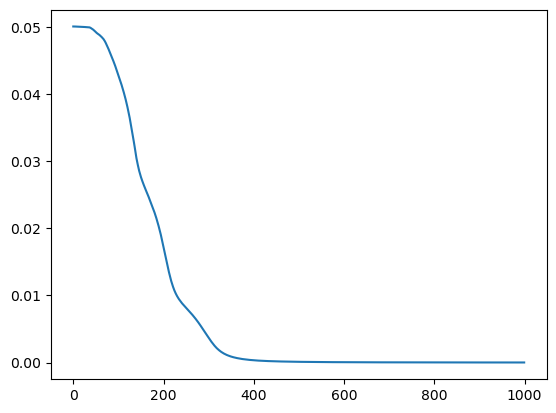

5.474133558891481e-06


In [9]:
# graph loss over iterations
plt.plot(lossi);
plt.show()
# print the final loss
print(lossi[-1])

In [10]:

# a function to get the prediction from the model using user input
def get_intention(inp, model):
    # make a list of the available positions for each label
    count = [0 for _ in range(len(words))]
    # stem the words got from the user input
    s_words = [stemmer.stem(w.lower()) for w in inp.split()]
    
    # loop through the list of stemmed words
    for se in s_words:
        # loop through each word in the global words list
        for i, w in enumerate(words):
            # if the current word is in the input
            if w == se:
                # activate it's current position
                count[i] = 1
    
    # make th input into a torch tensor with dimentions (1, 60)
    count = torch.tensor(count).view(1, 60)
    
    # initiate the intention value as an empty string
    intention = ""

    # do not mind the gradients of the following code
    with torch.no_grad():
        # predict the output of the model using the count vector
        output = model(count.float())
        # the output index of the predicted value
        output_index = output.argmax()
    
    # check if the model prediction accuracy is higher than 70%
    if output[0][output_index] > 0.7:
        # get the tag corresponding tag/intention predicted
        tag = labels[output.argmax()]
    # if the prediction is not within treshhold
    else:
        # the intention is unknown
        tag = "Unknown"
    
    
    
    # return the tag/intention
    return tag#, intention


In [11]:
# make a prediction
get_intention("what is the definition of existence", model)

'search_for_definition'